In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

from numpy import random
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.simplefilter("ignore")



To bring in the code from the 'from learntools.time_series.style import * command from the Kaggle learntools components, since it was very difficult to actually install learntools on a computer. 

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

get_ipython().config.InlineBackend.figure_format = 'retina'

To create the seasonal_plot function from the Kaggle learntools files.

In [3]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


To create the plot_periodograms function from the Kaggle learntools files.

In [4]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [5]:
test = pd.read_csv('test_features.csv')
train = pd.read_csv('train_features.csv')
holidays = pd.read_csv('holidays_events.csv')
oil = pd.read_csv('oil.csv')
stores = pd.read_csv('stores.csv')
transactions = pd.read_csv('transactions.csv')
submission = pd.read_csv('sample_submission.csv')

In [6]:
submission

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [7]:
test

,id,date,store_nbr,family,onpromotion,day_of_week,weekend,month,day_of_year,week_of_year,year,dcoilwtico,city,state,type,cluster,transactions,national_day,regional_day,local_day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,3,0,8,228,33,2017,46.80,Quito,Pichincha,D,13,0.0,None,None,None
1,3000889,2017-08-16,1,BABY CARE,0,3,0,8,228,33,2017,46.80,Quito,Pichincha,D,13,0.0,None,None,None
2,3000890,2017-08-16,1,BEAUTY,2,3,0,8,228,33,2017,46.80,Quito,Pichincha,D,13,0.0,None,None,None
3,3000891,2017-08-16,1,BEVERAGES,20,3,0,8,228,33,2017,46.80,Quito,Pichincha,D,13,0.0,None,None,None
4,3000892,2017-08-16,1,BOOKS,0,3,0,8,228,33,2017,46.80,Quito,Pichincha,D,13,0.0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029263,2017-08-31,54,POULTRY,0,4,0,8,243,35,2017,47.26,El Carmen,Manabi,C,3,0.0,None,None,None
28508,3029264,2017-08-31,54,PREPARED FOODS,0,4,0,8,243,35,2017,47.26,El Carmen,Manabi,C,3,0.0,None,None,None
28509,3029265,2017-08-31,54,PRODUCE,1,4,0,8,243,35,2017,47.26,El Carmen,Manabi,C,3,0.0,None,None,None
28510,3029266,2017-08-31,54,SCHOOL AND OFFICE SUPPLIES,0,4,0,8,243,35,2017,47.26,El Carmen,Manabi,C,3,0.0,None,None,None


# Seasonality Exercise - Looking at Dates

To bring up the holidays_events dataframe. 

In [8]:
holidays_events = pd.read_csv(
    'holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events = holidays_events.set_index('date').to_period('D')

In [9]:
holidays_events

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


To create a specific store sales dataframe from the train dataframe, just using all the columns except the 'id' and 'onpromotion' columns. It has the same number of rows as the train dataframe, but groups the store numbers and their product families together for all the days for all the years. 

In [10]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [11]:
store_sales

sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]

To create a new dataframe for aggregrated store sales by date for just the inlcuded 2017 dates through August 15. The length is 227 rows, which means that each date includes the average of all the sales for all the stores and products for that day. There appear to be 227 days between January 1 and August 15. 

In [12]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [13]:
average_sales

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 227, dtype: float32

To create a dataframe to list the average sales per day for all the stores for each product family.

In [14]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [15]:
family_sales

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055664  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259277  0.000000   
2017-08-13   8.907408  0.166667   8.018518  3747.296387  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629639  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462891  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305298   16.111111  1031.148193   831.648132  345.934967   
2017-08-12   507.473114   15.722222  1072.870361   793.592590  290.553589   
2017-08-13   615.976990   10.074074  1143.648193   928.000000  325.801361   
2017-08-14   518.564026   11.000000  1019.111084   797.222229  271.532227   
2017-08-15   539.966553   11.055555  1082.851807   753.833313  276.582458   

            ...                                                   \
family      ... MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...  0.074074    5.013166      2.629630     0.074074   
2017-01-02  ...  7.777778  488.522339    714.370361    12.814815   
2017-01-03  ...  3.500000  427.520905    488.333344     8.870370   
2017-01-04  ...  3.500000  369.121490    426.574066     8.129630   
2017-01-05  ...  3.203704  368.945679    360.925934     7.629630   
...         ...       ...         ...           ...          ...   
2017-08-11  ...  9.259259  498.964661    295.888885    10.870370   
2017-08-12  ...  8.944445  329.178711    294.500000     9.407408   
2017-08-13  ...  8.685185  345.055817    336.814819    10.018518   
2017-08-14  ...  8.462963  314.364563    279.203705     7.722222   
2017-08-15  ...  8.537037  332.003174    273.833344     6.740741   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-01                0.222222    2.855537       1.040722    31.163778   
2017-01-02               22.777779  581.413147     153.555542  3409.500488   
2017-01-03               13.555555  462.013672     125.820534  3394.559814   
2017-01-04               12.092592  431.276398     116.740814  3467.447998   
2017-01-05               10.333333  345.673492     101.434570  2069.316650   
...                            ...         ...            ...          ...   
2017-08-11               12.111111  468.857361      96.286926  2198.854492   
2017-08-12               13.185185  354.342773      84.693817  2070.154785   
2017-08-13               13.722222  379.801208      91.509422  2331.922363   
2017-08-14                9.259259  344.398285      86.062500  2134.399902   
201

To set up a new dataframe as X to show the average total sales per day and break out which week number and day number each day is. 

In [16]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek

In [17]:
X

,sales,week,day
date,,,
2017-01-01,6.780303,52,6
2017-01-02,786.928406,1,0
2017-01-03,619.740234,1,1
2017-01-04,555.608032,1,2
2017-01-05,436.375397,1,3
...,...,...,...
2017-08-11,463.733856,32,4
2017-08-12,444.798279,32,5
2017-08-13,485.768616,32,6


To run the graphs to show 2017 seasonality and the type of seasonality in the period graph. It shows that over that period weekly seems to have the strongest reoccuring pattern. 

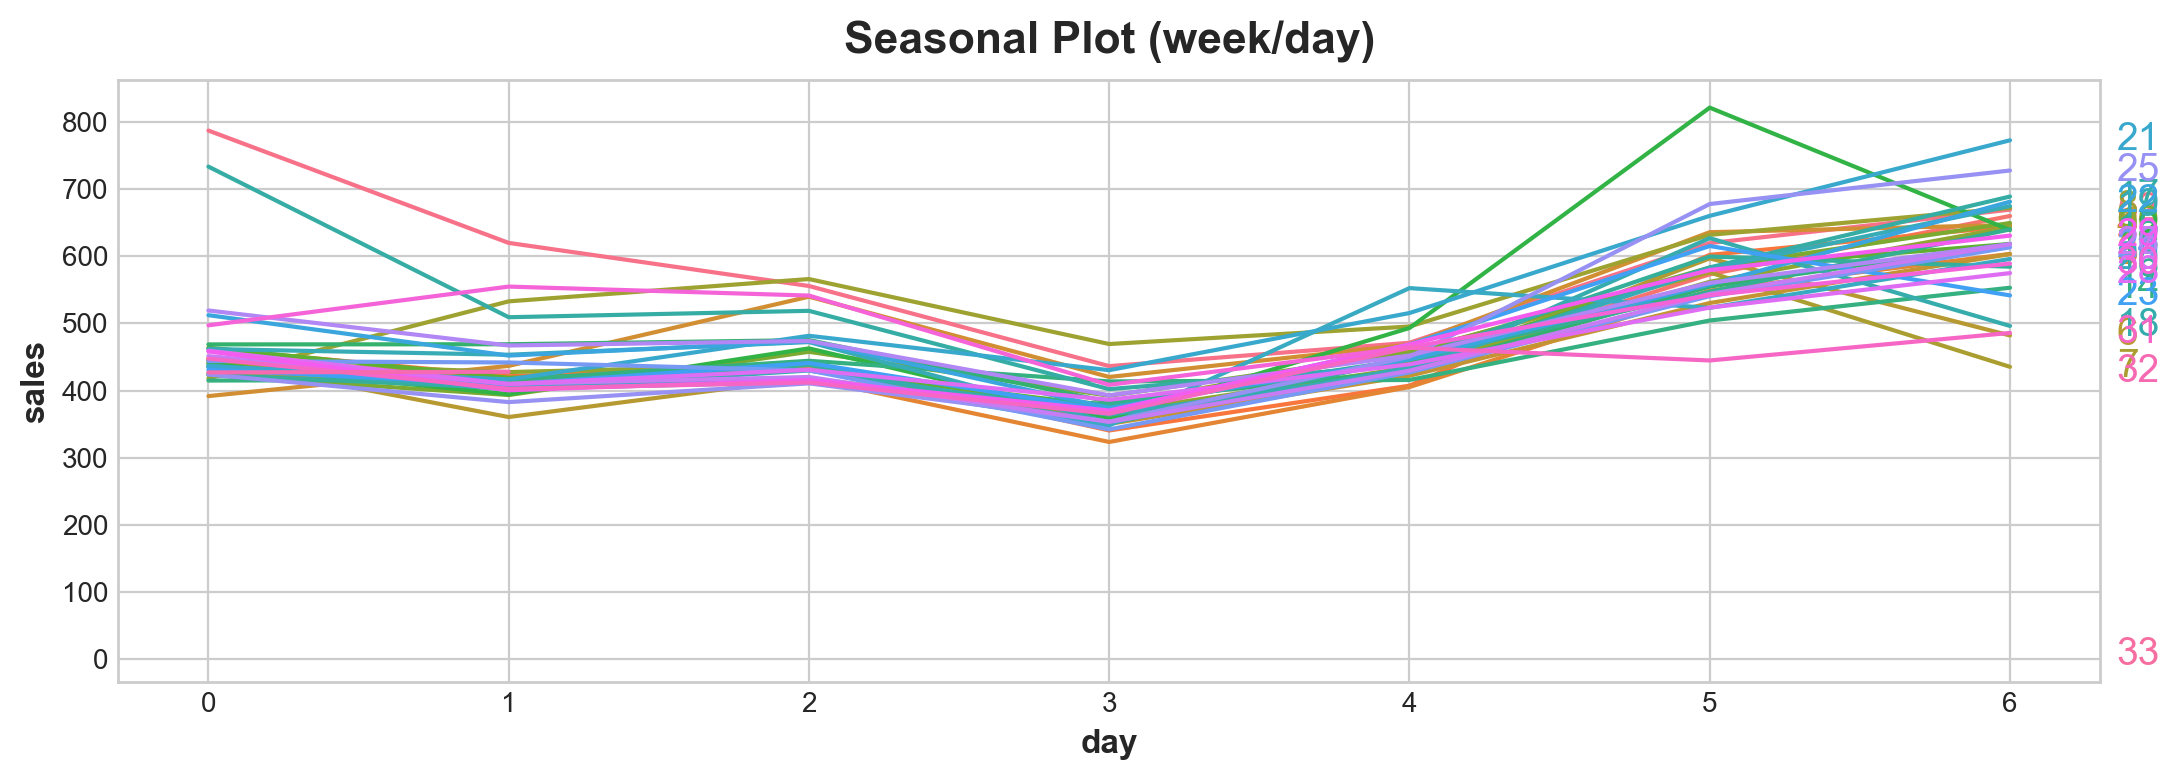

In [18]:
seasonal_plot(X, y='sales', period='week', freq='day');

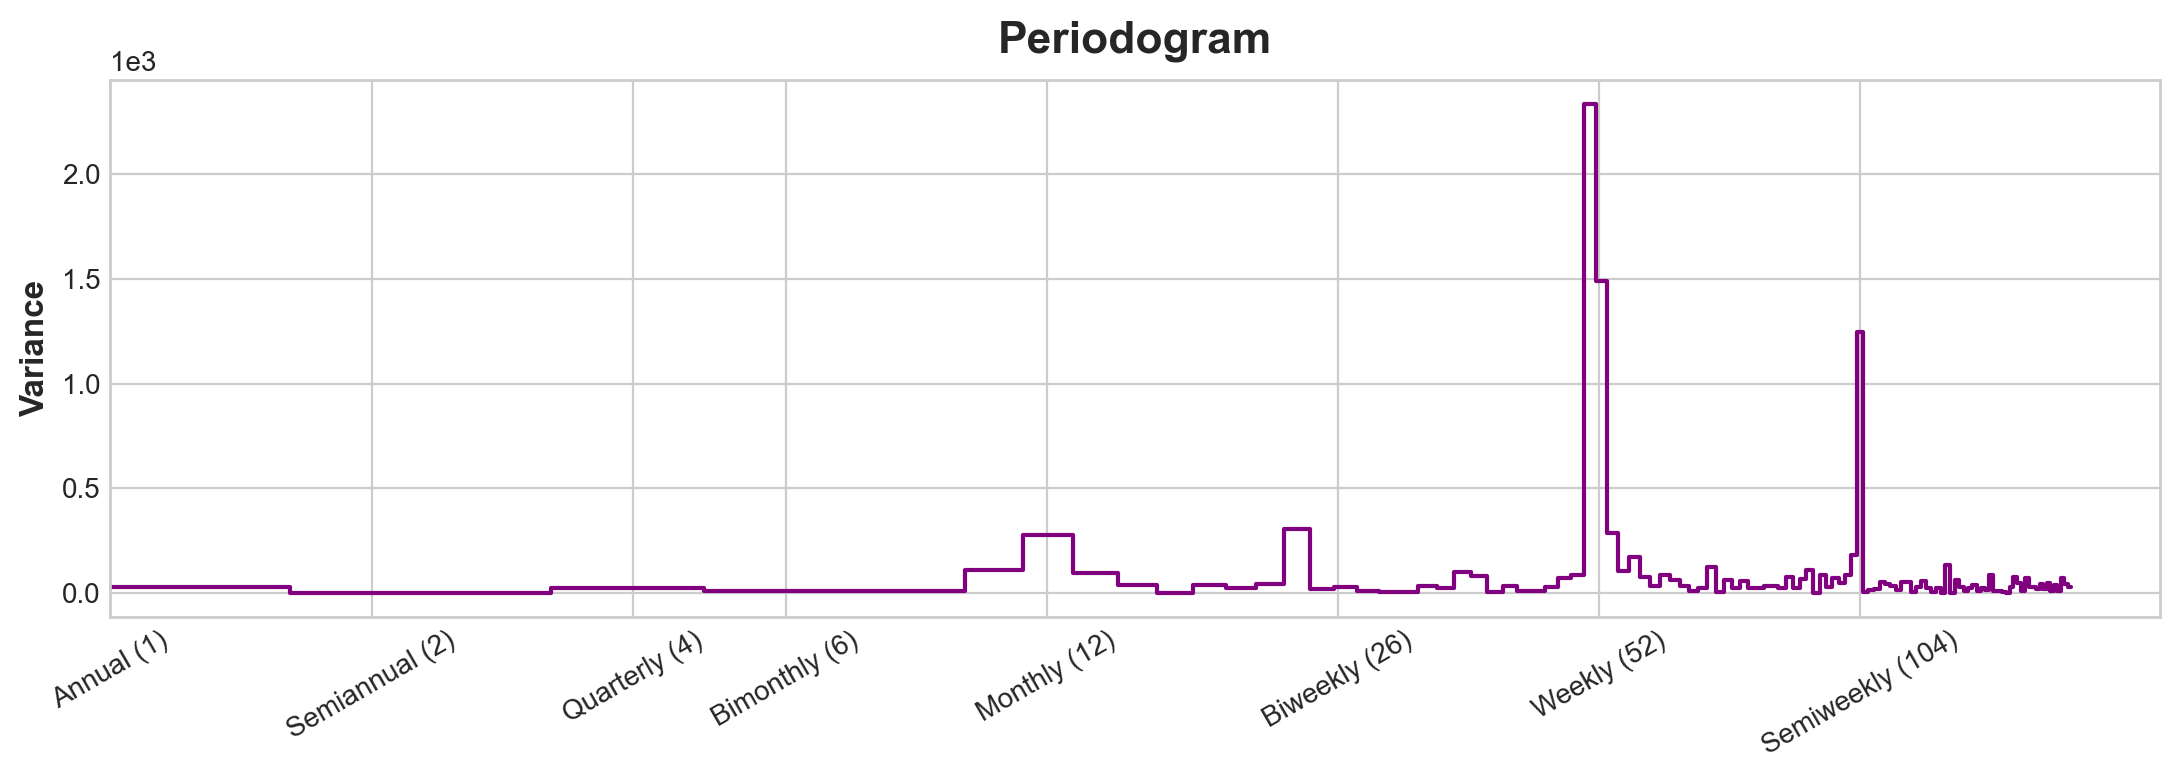

In [19]:
plot_periodogram(average_sales);

To create a dependent variable with the total average sales for each day. This would be offset against the X dataframe with the independent variables of week number and day number. This seems to set things up for how deterministic seasonality is for predicting future sales. 

In [20]:
y = average_sales.copy()

In [21]:
y

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 227, dtype: float32

Some notes on Fourier and Deterministic Proces

Fourier series is a technique of decomposing a periodic signal into a sum of sine and cosine terms. Fourier Transform is a mathematical operation for converting a signal from time domain into its frequency domain. The 'order' is the Fourier expansion order which should be understood as the number of waves you are expecting in your chosen frequency (count the number of ups and downs – one wave would be understood as one up and one down)

DeterministicProcess aims at creating features to be used in a Regression model to determine trend and periodicity. It takes your DatetimeIndex and a few other parameters and returns a DataFrame full of features for your ML model.

The DeterministicProcess class also helps us with future predictions since it carries a method that provides the appropriate future form of the chosen features. Specifically, the out_of_sample method of dp takes the number of time intervals we want to predict as input and generates the needed features for you.

In [22]:
fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,    
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

This process created 15 new features. It seems to have done a one hot encoding with days of the week, and then created 4 sine and cosine variables for the monthly fluctuations. This now became the X dataframe with the independent variables that will be used to predict future sales. 

In [23]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


A simple linear regression model is created, fitted and a prediction is made. 

In [24]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)

In [25]:
y_pred

date
2017-01-01    653.676295
2017-01-02    540.263341
2017-01-03    507.119635
2017-01-04    512.225921
2017-01-05    410.659846
                 ...    
2017-08-11    437.037533
2017-08-12    564.402698
2017-08-13    573.302878
2017-08-14    441.765064
2017-08-15    413.620123
Freq: D, Length: 227, dtype: float64

A graph is created to show the y dataframe average sales and plotted against the y_pred prediction line from the linear regression model. 

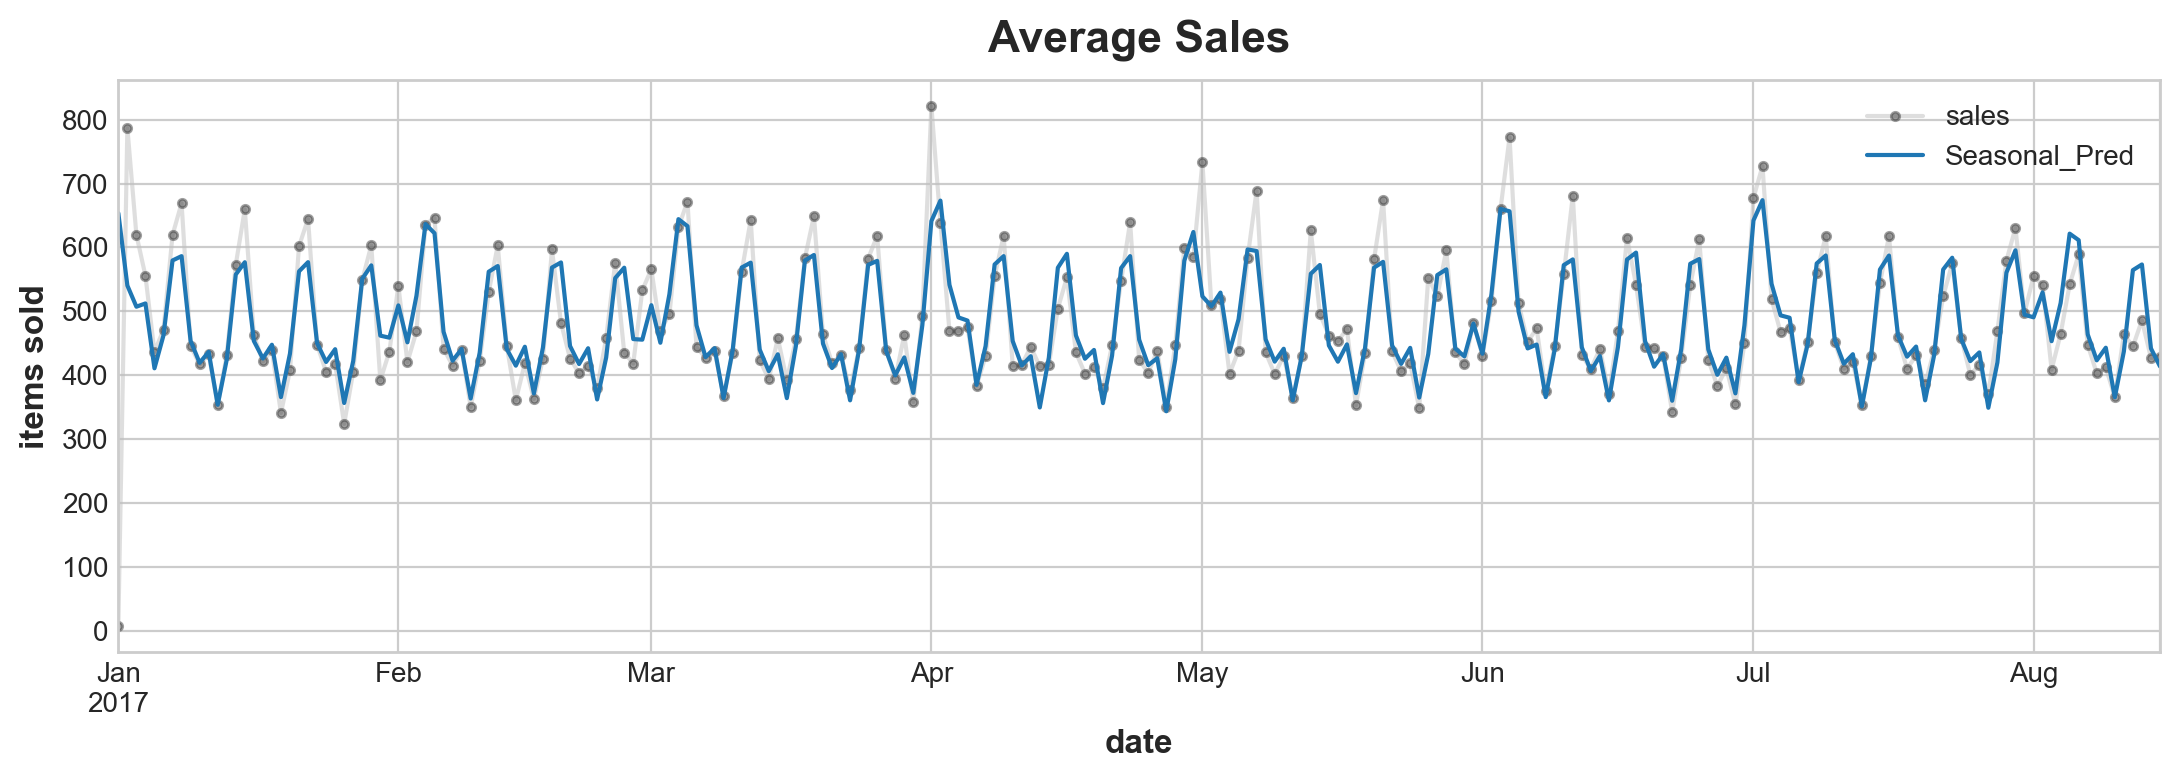

In [26]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal_Pred")
ax.legend();

To create the scoring function and then run the score on the model. With only 227 rows, these scores probably are not that accurate. 

In [27]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [28]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [29]:
mean_squared_log_error(y,y_pred)

0.0927420706842376

In [30]:
print(rmse_cv(model,X,y).mean())

55.25440017485709


# Kaggle Submission for Dates Seasonality

Creating an initial y value with all the sales information. 

In [31]:
y_prep = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

In [32]:
y_prep

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...           

In [33]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y_prep.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [34]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


In [35]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y_prep)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y_prep.columns)

In [36]:
y_pred

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-01   1.765397       0.0  1.878898  1070.645255  0.560145   187.388222   
2017-01-02   4.079200       0.0  3.609793  2390.697187  0.627466   425.536101   
2017-01-03   3.967442       0.0  3.735080  2525.305827  0.965860   421.781146   
2017-01-04   4.065468       0.0  3.603507  2709.553597  1.063590   497.962041   
2017-01-05   3.925240       0.0  3.107353  2341.551931  0.787991   442.750775   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   6.255772       0.0  3.618540  2285.313096  0.433766   351.545106   
2017-08-12   5.373726       0.0  4.278236  2426.128017  0.197833   369.023065   
2017-08-13   2.488187       0.0  2.039453   947.879104  0.144902   112.783123   
2017-08-14   4.381333       0.0  3.563143  2167.871646  0.127627   337.063640   
2017-08-15   4.136249       0.0  3.652089  2246.202303  0.405899   323.866908   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-01-01    2.367380  281.353516  397.210503   73.398371  ...  5.234403   
2017-01-02   12.676740  718.888945  818.624615  155.737751  ...  3.139039   
2017-01-03   14.891045  854.231997  830.070207  151.741886  ...  2.464900   
2017-01-04   15.474657  962.608308  975.875339  156.913529  ...  1.994945   
2017-01-05   19.012154  792.496314  820.733094  131.281480  ...  1.687774   
...                ...         ...         ...         ...  ...       ...   
2017-08-11   22.863347  694.303182  752.851278  163.872304  ...  5.031354   
2017-08-12   15.491724  590.103057  758.057952  136.939419  ...  5.932199   
2017-08-13    5.096150  177.178932  279.085908   53.075854  ...  6.624914   
2017-08-14   14.848330  588.015324  675.558052  134.372583  ...  4.612118   
2017-08-15   16.762616  714.518337  676.301456  132.715912  ...  4.002929   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01  539.902568    881.799145    11.944135               22.878748   
2017-01-02  496.427948    766.621140     9.241279               18.493067   
2017-01-03  465.658662    728.061803     8.009876               17.336639   
2017-01-04  419.305940    619.042010     8.433549               15.185911   
2017-01-05  588.232256    547.567985     5.914759               13.988446   
...                ...           ...          ...                     ...   
2017-08-11  262.495373    285.141890     7.159278                5.617524   
2017-08-12  375.437503    552.291489    10.209404               12.192030   
2017-08-13  378.744313    545.720685     9.867174               12.628408   
2017-08-14  328.012724    392.490285     6.735226                7.878011   
2017-08-15  323.290800    375.826590     6.079282                7.627723   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01  717.335228     172.717843  2451.638108                  -6.597805   
2017-01-02  564.011297     127.445206  1921.038769                  -5.989568   
20

In [37]:
print(rmse_cv(model,X,y_prep).mean())

285.2967400856699


In [38]:
mean_squared_log_error(y_prep,y_pred)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [39]:
df_test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [40]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

In [41]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

In [42]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530


In [43]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_prep.columns)

In [44]:
y_submit

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-16   4.301176       0.0  3.524422  2431.004576  0.446927   399.318569   
2017-08-17   4.257101       0.0  2.952524  2110.345641  0.093622   352.078637   
2017-08-18   5.382934       0.0  2.584540  2355.705479  0.055723   364.798072   
2017-08-19   4.493152       0.0  3.411646  2545.311946 -0.212999   392.950448   
2017-08-20   1.805959       0.0  1.505135  1099.818556 -0.246098   142.055387   
2017-08-21   4.144167       0.0  3.471358  2327.597168 -0.193967   364.601925   
2017-08-22   4.553857       0.0  4.017691  2383.623851  0.187936   342.933267   
2017-08-23   5.449534       0.0  4.240021  2515.831716  0.339959   405.555421   
2017-08-24   6.005028       0.0  3.796789  2116.793551  0.073052   344.578597   
2017-08-25   7.387696       0.0  3.277287  2266.589335  0.070927   345.770516   
2017-08-26   6.286961       0.0  3.705501  2355.868169 -0.221452   366.284837   
2017-08-27   2.952577       0.0  1.280603   821.374708 -0.323486   111.637066   
2017-08-28   4.404902       0.0  2.792380  1990.087341 -0.352300   333.288065   
2017-08-29   3.988361       0.0  3.116869  2034.807660 -0.023850   312.619515   
2017-08-30   4.400052       0.0  3.433213  2215.080559  0.131342   378.050816   
2017-08-31   4.964274       0.0  3.361001  1923.032377 -0.069555   322.492576   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-16   17.180526  828.581546  826.752632  142.386580  ...  3.557026   
2017-08-17   20.429147  671.743265  685.804810  121.471731  ...  3.176540   
2017-08-18   21.316073  720.107244  762.686050  173.571391  ...  3.426729   
2017-08-19   13.308338  636.478209  778.620388  148.749943  ...  4.081368   
2017-08-20    2.694671  234.079964  305.775446   64.432259  ...  4.890833   
2017-08-21   12.776664  645.784037  702.417629  142.840392  ...  3.187643   
2017-08-22   15.558135  764.922921  697.416648  136.594431  ...  2.893863   
2017-08-23   17.182131  864.648336  837.180448  141.018666  ...  2.637350   
2017-08-24   21.614550  687.125598  681.775765  115.213882  ...  2.287922   
2017-08-25   23.249654  709.128165  741.456419  163.537955  ...  2.478709   
2017-08-26   15.250592  595.585104  738.671403  136.511822  ...  3.109997   
2017-08-27    3.853038  164.431512  247.789134   51.796389  ...  4.051492   
2017-08-28   12.604198  555.648348  630.740588  131.713019  ...  2.685274   
2017-08-29   13.971716  670.176628  621.032697  128.832055  ...  2.880146   
2017-08-30   14.599241  786.271515  769.072405  138.167846  ...  3.118943   
2017-08-31   18.787499  645.959091  636.179591  118.138893  ...  3.086990   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-16  321.118813    328.085569     7.840929                7.241885   
2017-08-17  529.834363    323.220214     6.794033                7.889629   
2017-08-18  310.050015    289.644297     7.677393                6.826547   
2017-08-19  419.920598    560.542390    10.559085               13.226432   
2017-08-20  406.195818    546.595402     9.914249               13.250610   
2017-08-21  330.842451    380.512815     6.412834                7.894547   
2017-08-22  302.659436    352.256618     5.451773                6.953443   
2017-08

In [45]:
y_submit = y_submit.stack(['store_nbr', 'family'])

In [46]:
y_submit

sales
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     4.301176
                     BABY CARE                      0.000000
                     BEAUTY                         3.524422
                     BEVERAGES                   2431.004576
                     BOOKS                          0.446927
...                                                      ...
2017-08-31 9         POULTRY                      360.855966
                     PREPARED FOODS               105.059862
                     PRODUCE                     1233.803814
                     SCHOOL AND OFFICE SUPPLIES    45.052273
                     SEAFOOD                       18.557912

[28512 rows x 1 columns]

In [47]:
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

In [48]:
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.301176
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.524422
                     BEVERAGES                   3000891  2431.004576
                     BOOKS                       3000892     0.446927
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   360.855966
                     PREPARED FOODS              3029396   105.059862
                     PRODUCE                     3029397  1233.803814
                     SCHOOL AND OFFICE SUPPLIES  3029398    45.052273
                     SEAFOOD                     3029399    18.557912

[28512 rows x 2 columns]

In [49]:
y_submit.to_csv('./submissions/submit-exercise1-part1.csv', index=False)

Kaggle score of 0.51084

# Seasonality Exercise - Adding in Holidays

Next is to look at the seasonalilty around national and regional holidays for 2017. 

In [52]:
holidays_2017 = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays_2017)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


The red dots below are holidays and it shows there's potentially seasonal type variance around many of these dates. 

One hot encoding is used to create new features for each holiday. And this is added to the earlier fourier features. 

In [54]:
X_holidays_2017 = pd.get_dummies(holidays_2017)
X2 = X.join(X_holidays_2017, on='date').fillna(0.0)

In [55]:
X2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The linear regression model is now fitted against against this new model with the holidays added. 

In [56]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)

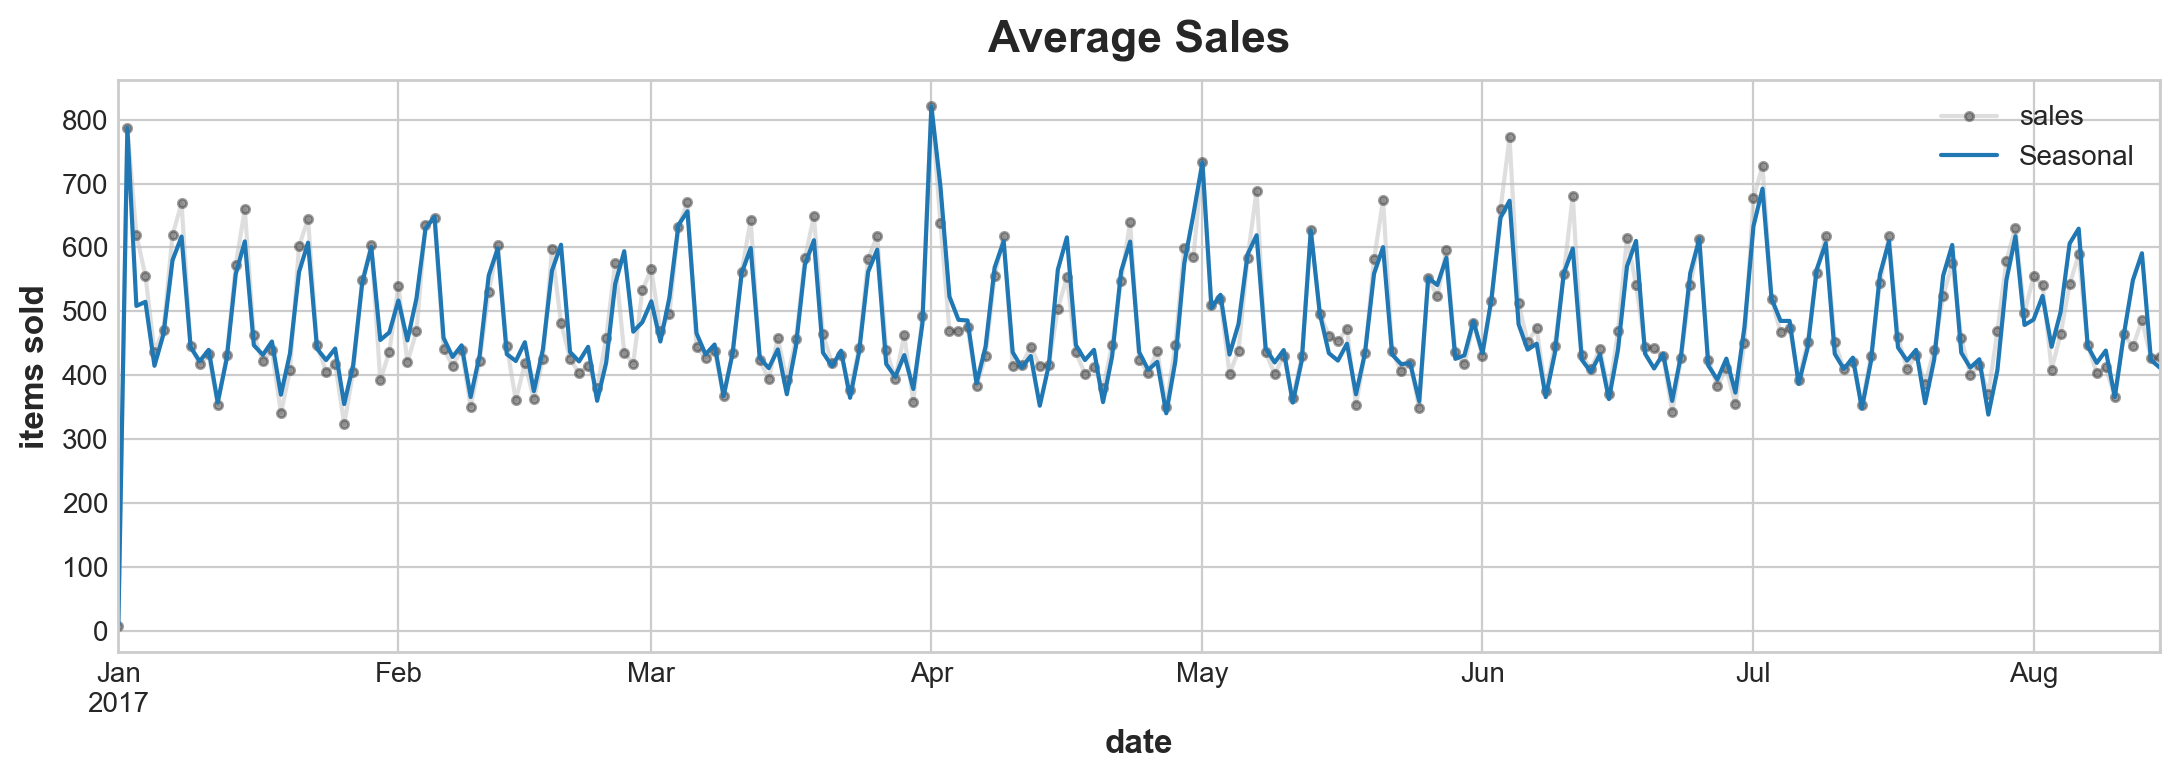

In [57]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [58]:
y_pred

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    508.296963
2017-01-04    514.809936
2017-01-05    414.646542
                 ...    
2017-08-11    463.733856
2017-08-12    548.718147
2017-08-13    590.797085
2017-08-14    423.607136
2017-08-15    411.462268
Freq: D, Length: 227, dtype: float64

Again, with only 227 rows, the scoring here probably isn't too accurate. But it does show a 3x improvement from the score above. 

In [59]:
mean_squared_log_error(y,y_pred)

0.003968845785915929

# Kaggle Submission for Holidays Seasonality

To create an initial y value with all the columns and the base sales information. 

In [60]:
y_prep = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

In [61]:
y_prep

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...           

In [62]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y_prep.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X2 = dp.in_sample()
X2['NewYear'] = (X2.index.dayofyear == 1)

In [63]:
X2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,False
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,False


In [64]:
model = LinearRegression(fit_intercept=False)
model.fit(X2, y_prep)
y_pred = pd.DataFrame(model.predict(X2), index=X2.index, columns=y_prep.columns)

In [65]:
y_pred

sales                                                      \
store_nbr              1                                                       
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01  2.131628e-14       0.0  2.708944e-14 -2.273737e-13  1.887379e-15   
2017-01-02  4.158065e+00       0.0  3.693728e+00  2.438526e+03  6.524888e-01   
2017-01-03  4.019103e+00       0.0  3.790063e+00  2.556636e+03  9.822520e-01   
2017-01-04  4.086815e+00       0.0  3.626226e+00  2.722500e+03  1.070364e+00   
2017-01-05  3.927327e+00       0.0  3.109574e+00  2.342817e+03  7.886527e-01   
...                  ...       ...           ...           ...           ...   
2017-08-11  6.230058e+00       0.0  3.591173e+00  2.269718e+03  4.256072e-01   
2017-08-12  5.340005e+00       0.0  4.242347e+00  2.405677e+03  1.871334e-01   
2017-08-13  2.504829e+00       0.0  2.057165e+00  9.579716e+02  1.501821e-01   
2017-08-14  4.341639e+00       0.0  3.520897e+00  2.143798e+03  1.150321e-01   
2017-08-15  4.103242e+00       0.0  3.616961e+00  2.226185e+03  3.954261e-01   

                                                                    \
store_nbr                                                            
family      BREAD/BAKERY   CELEBRATION      CLEANING         DAIRY   
date                                                                 
2017-01-01 -2.273737e-13  5.373479e-14  5.684342e-13  2.387424e-12   
2017-01-02  4.339072e+02  1.278250e+01  7.314578e+02  8.363691e+02   
2017-01-03  4.272647e+02  1.496032e+01  8.624653e+02  8.416939e+02   
2017-01-04  5.002280e+02  1.550328e+01  9.660105e+02  9.806785e+02   
2017-01-05  4.429722e+02  1.901495e+01  7.928288e+02  8.212025e+02   
...                  ...           ...           ...           ...   
2017-08-11  3.488156e+02  2.282886e+01  6.902050e+02  7.470656e+02   
2017-08-12  3.654437e+02  1.544650e+01  5.847289e+02  7.504708e+02   
2017-08-13  1.145495e+02  5.118466e+00  1.798311e+02  2.828302e+02   
2017-08-14  3.328502e+02  1.479510e+01  5.816891e+02  6.666268e+02   
2017-08-15  3.203635e+02  1.671835e+01  7.092581e+02  6.688751e+02   

                          ...                                            \
store_nbr                 ...             9                               
family              DELI  ...     MAGAZINES         MEATS PERSONAL CARE   
date                      ...                                             
2017-01-01  3.268497e-13  ...  3.108624e-14  1.023182e-12 -1.023182e-12   
2017-01-02  1.590167e+02  ...  3.372874e+00  5.205468e+02  8.060135e+02   
2017-01-03  1.538898e+02  ...  2.618076e+00  4.814580e+02  7.538661e+02   
2017-01-04  1.578011e+02  ...  2.058240e+00  4.258345e+02  6.297048e+02   
2017-01-05  1.313682e+02  ...  1.693960e+00  5.888703e+02  5.486101e+02   
...                  ...  ...           ...           ...           ...   
2017-08-11  1.628032e+02  ...  4.955111e+00  2.546313e+02  2.722978e+02   
2017-08-12  1.355374e+02  ...  5.832216e+00  3.651247e+02  5.354481e+02   
2017-08-13  5.376774e+01  ...  6.674256e+00  3.838337e+02  5.540330e+02   
2017-08-14  1.327222e+02  ...  4.494424e+00  3.158731e+02  3.726632e+02   
2017-08-15  1.313436e+02  ...  3.905065e+00  3.131967e+02  3.593403e+02   

                                                                              \
store_nbr                                                                      
family     PET SUPPLIES PLAYERS AND ELECTRONICS       POULTRY PREPARED FOODS   
date                                                                           
2017-01-01     0.000000            2.842171e-14  1.023182e-12   2.273737e-13   
2017-01-02     9.774855            1.951512e+01  5.960566e+02   1.351610e+02   
2017-01-03     8.359401            1.800615e+01  5.495394e+02   1.304207e+02   
2017-01-04     8.577979            1.546256e+01  4.735746e+02   1.162081e+02   
2

In [66]:
print(rmse_cv(model,X,y_prep).mean())

285.2967400856699


In [67]:
mean_squared_log_error(y_prep,y_pred)

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

Finally, this cell loads the test data, creates a feature set for the forecast period, and then creates the submission file

In [68]:
df_test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [69]:
df_test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

Create features for test set

In [70]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [71]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958,False
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958,False
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305,False
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394,False
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139,False
2017-08-21,1.0,233.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347,False
2017-08-22,1.0,234.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653,False
2017-08-23,1.0,235.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964,False
2017-08-24,1.0,236.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530,False


In [72]:
X_test.shape

(16, 17)

In [73]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_prep.columns)

In [74]:
y_submit

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-16   4.274030       0.0  3.495530  2414.541711  0.438314   396.437179   
2017-08-17   4.231962       0.0  2.925768  2095.099655  0.085646   349.410230   
2017-08-18   5.353637       0.0  2.553360  2337.938007  0.046427   361.688345   
2017-08-19   4.456659       0.0  3.372807  2523.180534 -0.224578   389.076928   
2017-08-20   1.819737       0.0  1.519799  1108.174532 -0.241726   143.517880   
2017-08-21   4.101538       0.0  3.425988  2301.744283 -0.207492   360.077059   
2017-08-22   4.518885       0.0  3.980471  2362.414521  0.176839   339.221133   
2017-08-23   5.422242       0.0  4.210974  2499.280285  0.331299   402.658530   
2017-08-24   5.980848       0.0  3.771054  2102.129170  0.065380   342.011984   
2017-08-25   7.358088       0.0  3.245775  2248.633266  0.061532   342.627780   
2017-08-26   6.246648       0.0  3.662596  2331.419763 -0.234243   362.005789   
2017-08-27   2.959719       0.0  1.288205   825.706177 -0.321220   112.395175   
2017-08-28   4.358269       0.0  2.742749  1961.806728 -0.367096   328.338290   
2017-08-29   3.961251       0.0  3.088016  2018.366494 -0.032452   309.741922   
2017-08-30   4.401427       0.0  3.434676  2215.914527  0.131778   378.196781   
2017-08-31   4.992727       0.0  3.391283  1940.287810 -0.060527   325.512685   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-16   17.144124  824.255291  820.644892  141.257964  ...  3.476538   
2017-08-17   20.395436  667.736792  680.148533  120.426538  ...  3.102002   
2017-08-18   21.276786  715.438153  756.094300  172.353338  ...  3.339864   
2017-08-19   13.259402  630.662323  770.409611  147.232718  ...  3.973167   
2017-08-20    2.713147  236.275821  308.875522   65.005106  ...  4.931685   
2017-08-21   12.719499  638.990190  692.826182  141.068040  ...  3.061248   
2017-08-22   15.511237  759.349348  689.547965  135.140419  ...  2.790170   
2017-08-23   17.145533  860.298807  831.039850  139.883978  ...  2.556429   
2017-08-24   21.582124  683.271964  676.335265  114.208561  ...  2.216228   
2017-08-25   23.209950  704.409512  734.794699  162.306972  ...  2.390922   
2017-08-26   15.196532  589.160338  729.601019  134.835755  ...  2.990469   
2017-08-27    3.862616  165.569773  249.396113   52.093334  ...  4.072668   
2017-08-28   12.541664  548.216521  620.248451  129.774234  ...  2.547010   
2017-08-29   13.935362  665.856074  614.933008  127.704927  ...  2.799765   
2017-08-30   14.601085  786.490672  769.381808  138.225019  ...  3.123020   
2017-08-31   18.825654  650.493624  642.581375  119.321844  ...  3.171352   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-16  312.816957    314.526513     7.657269                6.890088   
2017-08-17  522.146152    310.663396     6.623949                7.563836   
2017-08-18  301.090275    275.010746     7.479179                6.446872   
2017-08-19  408.760220    542.314634    10.312187               12.753503   
2017-08-20  410.409551    553.477506    10.007469               13.429170   
2017-08-21  317.805416    359.219999     6.124419                7.342094   
2017-08-22  291.964043    334.788303     5.215161                6.500219   
2017-08

In [75]:
y_submit = y_submit.stack(['store_nbr', 'family'])

In [76]:
y_submit

sales
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     4.274030
                     BABY CARE                      0.000000
                     BEAUTY                         3.495530
                     BEVERAGES                   2414.541711
                     BOOKS                          0.438314
...                                                      ...
2017-08-31 9         POULTRY                      372.417153
                     PREPARED FOODS               107.843530
                     PRODUCE                     1273.316507
                     SCHOOL AND OFFICE SUPPLIES    44.945937
                     SEAFOOD                       18.946715

[28512 rows x 1 columns]

In [77]:
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])

In [78]:
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.274030
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.495530
                     BEVERAGES                   3000891  2414.541711
                     BOOKS                       3000892     0.438314
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   372.417153
                     PREPARED FOODS              3029396   107.843530
                     PRODUCE                     3029397  1273.316507
                     SCHOOL AND OFFICE SUPPLIES  3029398    44.945937
                     SEAFOOD                     3029399    18.946715

[28512 rows x 2 columns]

In [79]:
y_submit.to_csv('./submissions/submit-exercise1.csv', index=False)

Kaggle score of 0.5109